In [2]:
import re 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from collections import defaultdict


### Preprocess Data

In [3]:
# # read amharic text from a file and return it as a string
# def load_data(file_path):
#     # read the file
#     with open(file_path, 'r', encoding='utf-8') as f:
#         return f.readlines()

# def consturct_paragraph(text):
#     paragraph = []
#     sentence = []
#     for line in text:
#         # remove the new line character and the leading and trailing white spaces
#         word = line.split(' ')[0].strip()
#         if word:
#             sentence.append(word)
#         # check if the word is a ge'ez script delimater
#         if re.findall(r'(፡፡|።|\?|!|::)', word):
#             # check if the sentence contains at list two words
#             if len(sentence) > 1:
#                 paragraph.append(sentence)
#             sentence = []
#     return paragraph

# def tokenize_text(text):
#     cleaned_text = []
#     for sentence in text:
#         punctuation_pattern = r"[.,;()?!/\[\]{}'\"<>@#$%^&*_+=|~\-]"
#         latin_pattern = r'[a-zA-Z0-9]+'
#         # remove the punctuation marks
#         cleaned_sentence = re.sub(punctuation_pattern, "፡፡", sentence)
#         # remove the latin characters
#         cleaned_sentence = re.sub(latin_pattern, '', cleaned_sentence)
#         # remove the extra white spaces
#         cleaned_sentence = re.sub(r"\s+", " ", cleaned_sentence).strip()
#         # check if the sentence contains at list two words
#         if len(sentence) > 1:
#             cleaned_text.append(cleaned_sentence)
    
#     tokenized_text = []
#     sentence = []
#     # pattern to split the text into words and delimaters
#     pattern = r'\w+|[^\s\w]+'
#     for line in cleaned_text:
#         # split the line into words and delimaters and iterate over the words
#         for word in re.findall(pattern, line):
#             # check if the word is a ge'ez script delimater
#             delimater = re.findall(r'(፡፡|።|::)', word)
#             if delimater:
#                 # add the delimater to the sentence
#                 sentence.append(delimater[-1]) 
#                 # add the sentence to the tokenized text
#                 tokenized_text.append(sentence)
#                 sentence = []
#             elif word:
#                 sentence.append(word)
            
#     return tokenized_text

# train_data, dev_data, test_data = load_data("../data/train.txt"), load_data("../data/dev.txt"), load_data( "../data/test.txt")
# train_data, dev_data, test_data = consturct_paragraph(train_data), consturct_paragraph(dev_data), consturct_paragraph(test_data)

# train_txt, dev_txt, test_txt = load_data("../data/train_.txt"), load_data("../data/dev_.txt"), load_data("../data/test_.txt")
# train_txt = tokenize_text(train_txt)
# dev_txt = tokenize_text(dev_txt)
# test_txt = tokenize_text(test_txt)
# train_data += train_txt
# dev_data += dev_txt
# test_data += test_txt
# print(len(train_data), len(dev_data), len(test_data))

### Build CBOW Word Embedding Models

In [56]:
class AmhCBOW:
    def __init__(self, window_size=2, embedding_size=100, alpha=0.01, epochs=10):
        # initialize the hyperparameters
        self.word2index = {}
        self.index2word = {}
        self.vocab = set()
        self.vocab_size = 0
        self.word_freq = defaultdict(int)
        self.word_count = 0
        self.window_size = window_size
        self.embedding_size = embedding_size
        self.alpha = alpha
        self.epochs = epochs
        self.W1 = None
        self.b1 = None
        self.W2 = None
        self.b2 = None
        self.h = []
        self.u = []
        self.y_hat = []
        self.loss = []
    
    def build_vocab(self, data):
        '''
        Initialize the word2index and index2word dictionaries and the vocab set
        Parameters:
            data: list of list of strings
        Returns:
            None
        '''

        # build the vocab set and the word frequency dictionary
        for sentence in data:
            for word in sentence:
                self.word_freq[word] += 1
                self.word_count += 1
                self.vocab.add(word)

        # set the vocab size
        self.vocab_size = len(self.vocab)

        # build the word2index and index2word dictionaries
        for i, word in enumerate(sorted(self.vocab)):
            self.word2index[word] = i
            self.index2word[i] = word
    
    def initialize_weights(self):
        '''
        Initialize the weights and bias for the hidden layer and the output layer
        Parameters:
            None
        Returns:
            None
        '''
        self.W1 = np.random.uniform(-1, 1, (self.embedding_size , self.vocab_size))
        self.b1 = np.zeros((self.embedding_size, 1))
        self.W2 = np.random.uniform(-1, 1, (self.vocab_size, self.embedding_size))
        self.b2 = np.zeros((self.vocab_size, 1))
    
    def softmax(self, z):
        '''
        Compute the softmax of the input
        Parameters:
            z: numpy array
        Returns:
            numpy array
        '''
        exp = np.exp(z - np.max(z))
        return exp / exp.sum(axis=0)

    def forward_propagation(self, x, y):
        '''
        Compute the forward propagation
        Parameters:
            context: list of integers that represent the context 
        Returns:
            None
        '''
        
        # Compute the hidden layer
        self.h = self.W1 @ x + self.b1
        # Apply ReLU activation function on h
        self.h = np.maximum(0, self.h)
        # Compute the output layer
        self.u = self.W2 @ self.h + self.b2
        # Compute the softmax of the output layer
        self.y_hat = self.softmax(self.u) * y
    
    def compute_loss(self, y):
        '''
        Compute the loss
        Parameters:
            target: integer
        Returns:
            current loss: float
        '''
        self.loss.append((-1 / self.word_count) * np.sum(self.y_hat))
        return self.loss[-1]
    
    def back_propagation(self, x, y):
        '''
        Compute the back propagation
        Parameters:
            target: integer
        Returns:
            None
        '''
        z1 = self.W1 @ x + self.b1
        l1 = self.W2.T @ (self.y_hat - y) /  self.word_count
        l1[z1 < 0] = 0

        dW1 = l1 @ x.T
        db1 = np.sum(l1, axis=1, keepdims=True)
        dW2 = (self.y_hat - y) @ self.h.T  / self.word_count
        db2 = np.sum(self.y_hat - y, axis=1, keepdims=True) / self.word_count

        self.W1 -= self.alpha * dW1
        self.b1 -= self.alpha * db1
        self.W2 -= self.alpha * dW2
        self.b2 -= self.alpha * db2
    
    def word_to_one_hot(self, word):
        '''
        Convert the word to one hot encoding
        Parameters:
            word: string
        Returns:
            numpy array
        '''
        one_hot = np.zeros(self.vocab_size)
        one_hot[self.word2index[word]] = 1
        return one_hot
    
    def context_to_one_hot(self, context):
        '''
        Convert the context to one hot encoding
        Parameters:
            context: list of words
        Returns:
            numpy array
        '''
        one_hot = [self.word_to_one_hot(word) for word in context]
        one_hot = np.mean(one_hot, axis=0)
        return one_hot
    
    def train(self, data):
        '''
        Train the model
        Parameters:
            data: list of list of strings
        Returns:
            None
        '''
        self.build_vocab(data)
        self.initialize_weights()
        x, y = [], []
        for sentence in data:
                for i in range(self.window_size, len(sentence) - self.window_size):
                    context_words = sentence[i - self.window_size: i] + sentence[i + 1: i + self.window_size + 1]
                    word = sentence[i]
                    x.append(self.context_to_one_hot(context_words))
                    y.append(self.word_to_one_hot(word)) 

        x = np.array(x).T 
        y = np.array(y).T 

        for _ in range(self.epochs):
            self.forward_propagation(x, y)
            self.compute_loss(y)
            self.back_propagation(x, y)
    
    def get_embedding(self, word):
        '''
        Get the embedding of the word
        Parameters:
            word: string
        Returns:
            numpy array
        '''
        return (self.W1[self.word2index[word]].T + self.W2[self.word2index[word]]) / 2
    
    def get_similar_words(self, word, n=5):
        '''
        Get the most similar words to the input word
        Parameters:
            word: string
            n: integer
        Returns:
            list of strings
        '''
        word_embedding = self.get_embedding(word)
        similarity = np.dot(self.W1, word_embedding)
        similar_words = [self.index2word[i] for i in np.argsort(similarity)[::-1][:n]]
        return similar_words

    def plot_loss(self):
        '''
        Plot the loss
        Parameters:
            None
        Returns:
            None
        '''
        plt.plot(self.loss)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Loss vs Epoch")
        plt.show()
    
    def plot_embedding(self, words):
        '''
        Plot the embedding of the words
        Parameters:
            words: list of strings
        Returns:
            None
        '''
        embeddings = np.array([self.get_embedding(word) for word in words])
        sns.set(rc={'figure.figsize':(11.7,8.27)})
        sns.heatmap(embeddings, xticklabels=False, yticklabels=words)
        plt.show()
    
    def save_model(self, file_path):
        '''
        Save the model
        Parameters:
            file_path: string
        Returns:
            None
        '''
        model = {
            "word2index": self.word2index,
            "index2word": self.index2word,
            "vocab_size": self.vocab_size,
            "embedding_size": self.embedding_size,
            "W1": self.W1,
            "b1": self.b1,
            "W2": self.W2,
            "b2": self.b2
        }
        np.save(file_path, model)
    
    def load_model(self, file_path):
        '''
        Load the model
        Parameters:
            file_path: string
        Returns:
            None
        '''
        model = np.load(file_path, allow_pickle=True).item()
        self.word2index = model["word2index"]
        self.index2word = model["index2word"]
        self.vocab_size = model["vocab_size"]
        self.embedding_size = model["embedding_size"]
        self.W1 = model["W1"]
        self.b1 = model["b1"]
        self.W2 = model["W2"]
        self.b2 = model["b2"]
    
    def predict(self, context):
        '''
        Predict the word
        Parameters:
            context: list of integers
        Returns:
            string
        '''
        self.forward_propagation(context)
        return self.index2word[np.argmax(self.y)]
    
    # def evaluate(self, data):
    #     '''
    #     Evaluate the model
    #     Parameters:
    #         data: list of list of strings
    #     Returns:
    #         float
    #     '''
    #     correct = 0
    #     total = 0
    #     for sentence in data:
    #         for i, word in enumerate(sentence):
    #             context = [self.word2index[sentence[j]] for j in range(max(0, i - self.window_size), min(i + self.window_size + 1, len(sentence))) if j != i]
    #             prediction = self.predict(context)
    #             if prediction == word:
    #                 correct += 1
    #             total += 1
    #     return correct / total        

### Amharic Langauge Word Embedding with CBOW

[ 0.72272992  0.6037203  -0.84728934  0.64104003  0.3610359   0.83467772]


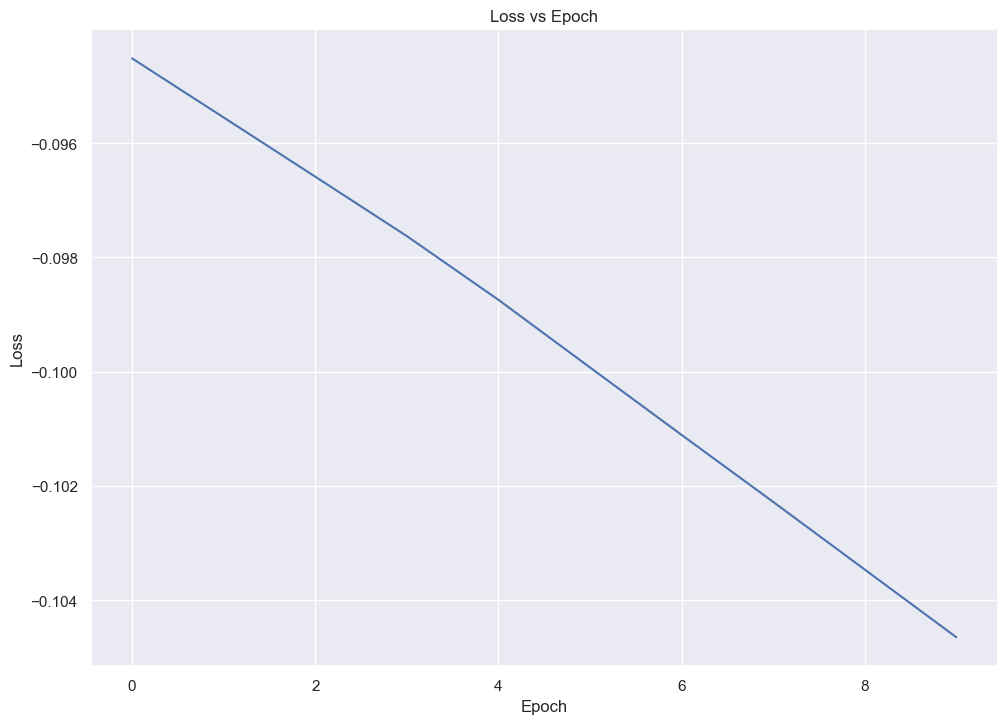

In [59]:
# create an instance of the AmhCBOW
cbow = AmhCBOW(window_size=2, embedding_size=100, alpha=0.01, epochs=10)
data = [['አበበ','በሶ','በላ','እና','ጠጣ','።']]
cbow.train(data)
print(cbow.get_embedding('በላ'))
#print(cbow.get_similar_words('በላ'))
cbow.plot_loss()